# 1. Import thư viện

In [2]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.metrics import RootMeanSquaredError
from keras.layers import InputLayer, Dense, SimpleRNN, LSTM, Bidirectional, Conv1D, MaxPooling1D, Dropout

import warnings
warnings.filterwarnings("ignore")

# 2. Load dữ liệu và tiền xử lý

## 2.1 Load dữ liệu

In [3]:
# load dữ liệu
df = pd.read_csv('./dataset/data_chungkhoan_VCB.csv')
df

,Ngày,Giá điều chỉnh,Giá đóng cửa,Thay đổi (+/-%),GD khớp lệnh_KL,GD khớp lệnh_GT,GD thỏa thuận_KL,GD thỏa thuận_GT,Giá mở cửa,Giá cao nhất,Giá thấp nhất
0,24/03/2023,89.00,89.0,-1.70 (-1.87 %),"630,000","56,383,000,000","43,000","3,762,500,000",91.0,91.0,88.9
1,23/03/2023,90.70,90.7,1.70 (1.91 %),"849,500","75,853,000,000","1,096,000","97,342,400,000",88.8,90.7,87.3
2,22/03/2023,89.00,89.0,2.50 (2.89 %),"1,055,800","93,158,000,000","43,000","3,848,500,000",86.6,89.9,86.6
3,21/03/2023,86.50,86.5,1.40 (1.65 %),"1,057,400","91,918,000,000","116,000","10,261,000,000",85.4,89.9,85.4
4,20/03/2023,85.10,85.1,-3.90 (-4.38 %),"1,034,000","90,420,000,000","43,000","3,870,000,000",89.0,89.5,85.1
...,...,...,...,...,...,...,...,...,...,...,...
2047,09/01/2015,19.29,36.9,2.30 (6.65 %),"2,286,680","83,558,466,000","247,301","9,052,206,000",34.9,37.0,34.9
2048,08/01/2015,18.09,34.6,1.00 (2.98 %),"904,240","31,296,505,000","100,000","3,469,000,000",33.7,35.0,33.6
2049,07/01/2015,17.56,33.6,-0.40 (-1.18 %),"1,430,340","48,671,177,000","134,000","4,523,562,000",34.1,34.6,33.1
2050,06/01/2015,17.77,34.0,2.10 (6.58 %),"1,684,600","56,234,910,000",0,0,31.9,34.0,31.9


In [4]:
# hiển thị thông tin dữ liệu
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2052 entries, 0 to 2051
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Ngày              2052 non-null   object 
 1   Giá điều chỉnh    2052 non-null   float64
 2   Giá đóng cửa      2052 non-null   float64
 3   Thay đổi (+/-%)   2052 non-null   object 
 4   GD khớp lệnh_KL   2052 non-null   object 
 5   GD khớp lệnh_GT   2052 non-null   object 
 6   GD thỏa thuận_KL  2052 non-null   object 
 7   GD thỏa thuận_GT  2052 non-null   object 
 8   Giá mở cửa        2052 non-null   float64
 9   Giá cao nhất      2052 non-null   float64
 10  Giá thấp nhất     2052 non-null   float64
dtypes: float64(5), object(6)
memory usage: 176.5+ KB


In [5]:
# kiểm tra NaN
df.isna().sum()

Ngày                0
Giá điều chỉnh      0
Giá đóng cửa        0
Thay đổi (+/-%)     0
GD khớp lệnh_KL     0
GD khớp lệnh_GT     0
GD thỏa thuận_KL    0
GD thỏa thuận_GT    0
Giá mở cửa          0
Giá cao nhất        0
Giá thấp nhất       0
dtype: int64

In [6]:
# kiểm tra duplicate
df.duplicated().sum()

20

In [7]:
df = df.drop_duplicates()
df.duplicated().sum()

0

## 2.2 Tiền xử lý dữ liệu

In [8]:
# loại bỏ cột không mang nhiều ý nghĩa
df = df.drop(['Thay đổi (+/-%)'], axis=1)
df.head()

,Ngày,Giá điều chỉnh,Giá đóng cửa,GD khớp lệnh_KL,GD khớp lệnh_GT,GD thỏa thuận_KL,GD thỏa thuận_GT,Giá mở cửa,Giá cao nhất,Giá thấp nhất
0,24/03/2023,89.0,89.0,"630,000","56,383,000,000","43,000","3,762,500,000",91.0,91.0,88.9
1,23/03/2023,90.7,90.7,"849,500","75,853,000,000","1,096,000","97,342,400,000",88.8,90.7,87.3
2,22/03/2023,89.0,89.0,"1,055,800","93,158,000,000","43,000","3,848,500,000",86.6,89.9,86.6
3,21/03/2023,86.5,86.5,"1,057,400","91,918,000,000","116,000","10,261,000,000",85.4,89.9,85.4
4,20/03/2023,85.1,85.1,"1,034,000","90,420,000,000","43,000","3,870,000,000",89.0,89.5,85.1


In [9]:
df['Ngày'] = pd.to_datetime(df['Ngày'], format='%d/%m/%Y')
df = df.set_index('Ngày')           
df = df.sort_index(ascending=True)  # sắp xếp dữ liệu lại theo thứ tự tăng dần của Ngày
df.head()

,Giá điều chỉnh,Giá đóng cửa,GD khớp lệnh_KL,GD khớp lệnh_GT,GD thỏa thuận_KL,GD thỏa thuận_GT,Giá mở cửa,Giá cao nhất,Giá thấp nhất
Ngày,,,,,,,,,
2015-01-05,16.67,31.9,"310,010","9,858,049,000",0,0,31.7,32.1,31.4
2015-01-06,17.77,34.0,"1,684,600","56,234,910,000",0,0,31.9,34.0,31.9
2015-01-07,17.56,33.6,"1,430,340","48,671,177,000","134,000","4,523,562,000",34.1,34.6,33.1
2015-01-08,18.09,34.6,"904,240","31,296,505,000","100,000","3,469,000,000",33.7,35.0,33.6
2015-01-09,19.29,36.9,"2,286,680","83,558,466,000","247,301","9,052,206,000",34.9,37.0,34.9


In [10]:
# convert string -> number
for col in ['GD khớp lệnh_KL', 'GD khớp lệnh_GT', 'GD thỏa thuận_KL', 'GD thỏa thuận_GT']:
    df[col] = pd.to_numeric(df[col].str.replace(',',''))
df.head()

,Giá điều chỉnh,Giá đóng cửa,GD khớp lệnh_KL,GD khớp lệnh_GT,GD thỏa thuận_KL,GD thỏa thuận_GT,Giá mở cửa,Giá cao nhất,Giá thấp nhất
Ngày,,,,,,,,,
2015-01-05,16.67,31.9,310010,9858049000,0,0,31.7,32.1,31.4
2015-01-06,17.77,34.0,1684600,56234910000,0,0,31.9,34.0,31.9
2015-01-07,17.56,33.6,1430340,48671177000,134000,4523562000,34.1,34.6,33.1
2015-01-08,18.09,34.6,904240,31296505000,100000,3469000000,33.7,35.0,33.6
2015-01-09,19.29,36.9,2286680,83558466000,247301,9052206000,34.9,37.0,34.9


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2032 entries, 2015-01-05 to 2023-03-24
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Giá điều chỉnh    2032 non-null   float64
 1   Giá đóng cửa      2032 non-null   float64
 2   GD khớp lệnh_KL   2032 non-null   int64  
 3   GD khớp lệnh_GT   2032 non-null   int64  
 4   GD thỏa thuận_KL  2032 non-null   int64  
 5   GD thỏa thuận_GT  2032 non-null   int64  
 6   Giá mở cửa        2032 non-null   float64
 7   Giá cao nhất      2032 non-null   float64
 8   Giá thấp nhất     2032 non-null   float64
dtypes: float64(5), int64(4)
memory usage: 158.8 KB


In [12]:
df.describe()

,Giá điều chỉnh,Giá đóng cửa,GD khớp lệnh_KL,GD khớp lệnh_GT,GD thỏa thuận_KL,GD thỏa thuận_GT,Giá mở cửa,Giá cao nhất,Giá thấp nhất
count,2032.000000,2032.000000,2.032000e+03,2.032000e+03,2.032000e+03,2.032000e+03,2032.000000,2032.000000,2032.000000
mean,51.151742,66.000615,1.246755e+06,8.321239e+10,1.303525e+05,9.456251e+09,65.949090,66.804355,65.154946
std,22.516470,21.814038,8.281467e+05,6.286998e+10,7.585487e+05,6.224268e+10,21.807825,22.031471,21.520308
min,16.670000,31.900000,6.190000e+04,2.355000e+09,0.000000e+00,0.000000e+00,31.700000,32.100000,31.400000
25%,27.510000,44.400000,6.816025e+05,3.768850e+10,0.000000e+00,0.000000e+00,44.275000,45.100000,43.900000
50%,50.810000,66.700000,1.040995e+06,6.856056e+10,2.000000e+04,1.525820e+09,66.700000,67.500000,65.900000
75%,73.550000,84.250000,1.561000e+06,1.090212e+11,1.000000e+05,7.094250e+09,84.100000,85.100000,83.225000
max,96.000000,116.400000,7.265480e+06,6.384660e+11,2.759500e+07,2.290581e+12,116.700000,117.200000,115.000000


# 3. Chuẩn hóa dữ liệu

## 3.1 Trực quan hóa dữ liệu

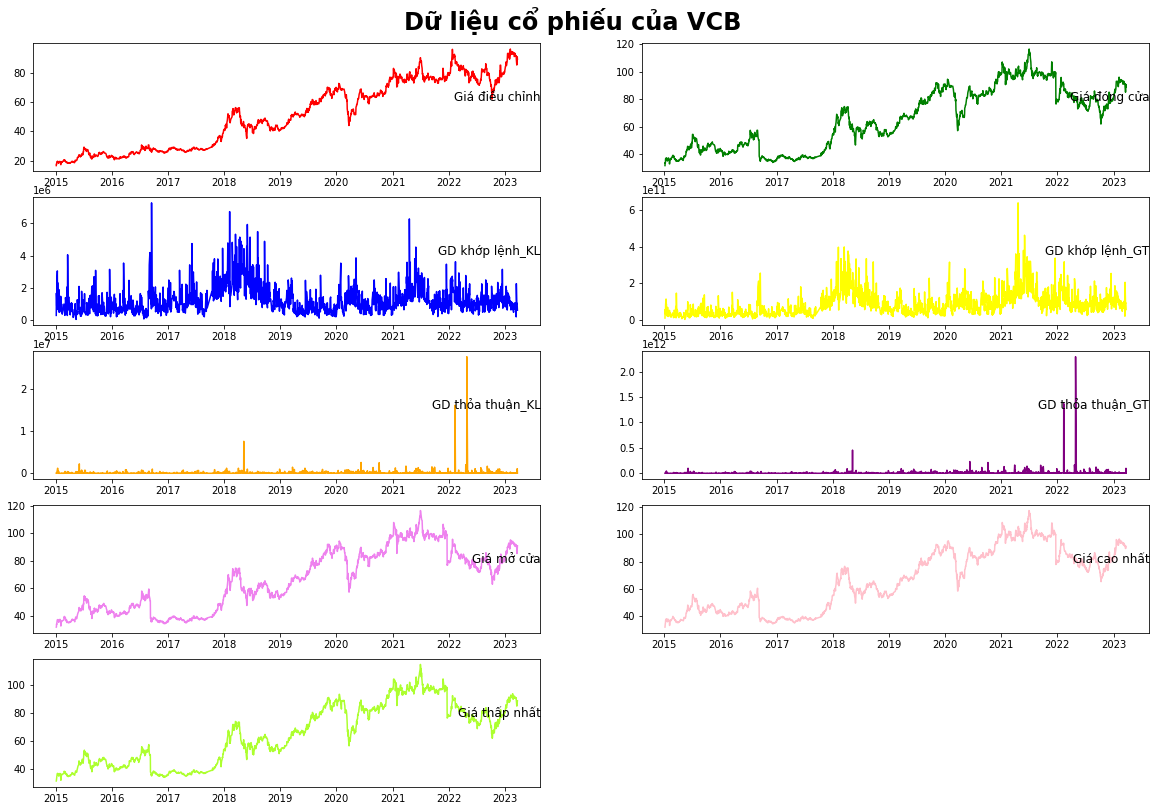

In [13]:
no_cols = len(df.columns)
colors = ['red', 'green', 'blue', 'yellow', 'orange', 'purple', 'violet', 'pink', 'greenyellow']

plt.figure(figsize=(20,25))
for idx, column in enumerate(df.columns):
    plt.subplot(no_cols,2,idx+1)    
    plt.plot(df[column], color=colors[idx])
    plt.title(column,loc='right',y=0.5)
plt.suptitle('Dữ liệu cổ phiếu của VCB', y=0.9, fontweight='bold', fontsize='24')
plt.show()

## 3.2 Chuẩn hóa dữ liệu

In [14]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df)

# 4. Tạo dữ liệu traning

## 4.1 Chia tập dữ liệu: train(90%), test(10%)

In [15]:
def split_Train_Test(dataset):
    n = len(dataset)
    return {'train' : dataset[0:int(n*0.9)],
            'test' : dataset[int(n*0.9):]}

data_split = split_Train_Test(data_scaled)  # dùng để huấn luyện
index_split= split_Train_Test(df.index)     # dùng để vẽ biểu đồ

print(data_split['train'].shape)
print(index_split['train'].shape)
print(data_split['test'].shape)
print(index_split['test'].shape)

(1828, 9)
(1828,)
(204, 9)
(204,)


## 4.2 Tạo các lô dữ liệu cho dữ liệu training

In [16]:
def generatorData(data_split, n_input=14):
    x_train, y_train = [], []
    x_test, y_test = [], []
    # train
    for i in range(n_input, len(data_split['train'])):
        x_train.append(data_split['train'][i-n_input:i, :])
        y_train.append(data_split['train'][i, :])
    # test
    for i in range(n_input, len(data_split['test'])):
        x_test.append(data_split['test'][i-n_input:i, :])
        y_test.append(data_split['test'][i, :])

    x_train, y_train = np.array(x_train), np.array(y_train)
    x2d_train = np.array([x.flatten() for x in x_train])
    x_test, y_test = np.array(x_test), np.array(y_test)
    x2d_test = np.array([x.flatten() for x in x_test])

    return {'x_train' : x_train,
            'x2d_train' : x2d_train,
            'y_train' : y_train,
            'x_test' : x_test,
            'x2d_test' : x2d_test,
            'y_test' : y_test} 

data = generatorData(data_split, n_input=14)
print(data['x_train'].shape)
print(data['x2d_train'].shape)
print(data['y_train'].shape)

(1814, 14, 9)
(1814, 126)
(1814, 9)


# 5. Xây dựng và training model

In [17]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC

def create_model(name_model, n_input, n_features):
    if name_model == 'KNN':
        model = KNeighborsRegressor()
    elif name_model == 'DT':
        model = DecisionTreeRegressor()
    elif name_model == 'Random Forest':
        model = RandomForestRegressor()
    elif name_model == 'SVC':
        model = SVC()
    elif name_model == 'LR':
        model = LinearRegression()
    elif name_model == 'RNN':
        model =  Sequential([
            InputLayer((n_input, n_features)),
            SimpleRNN(64, activation='relu', return_sequences = True),
            SimpleRNN(32, activation='relu', return_sequences = True),
            SimpleRNN(16, activation='relu', return_sequences = False),
            Dense(n_features)
        ])

    elif name_model == 'LSTM':
        model = Sequential([
            InputLayer((n_input, n_features)),
            LSTM(64, activation='relu', return_sequences = True),
            LSTM(32, activation='relu', return_sequences = True),
            LSTM(16, activation='relu', return_sequences = False),
            Dense(n_features)
        ])

    elif name_model == 'BiLSTM':
        model = Sequential([
            InputLayer((n_input, n_features)),
            Bidirectional(LSTM(64, activation='relu', return_sequences = True)),
            Bidirectional(LSTM(32, activation='relu', return_sequences = True)),
            Bidirectional(LSTM(16, activation='relu', return_sequences = False)),
            Dense(n_features)
        ])
    elif name_model == 'RNN+CNN':
        model =  Sequential([
            InputLayer((n_input, n_features)),
            Conv1D(filters=64, kernel_size=2, activation="relu"),
            SimpleRNN(64, activation='relu', return_sequences = True),
            SimpleRNN(32, activation='relu', return_sequences = True),
            SimpleRNN(16, activation='relu', return_sequences = False),
            Dense(n_features)
        ])

    elif name_model == 'LSTM+CNN':
        model = Sequential([
            InputLayer((n_input, n_features)),
            Conv1D(filters=64, kernel_size=2, activation="relu"),
            LSTM(64, activation='relu', return_sequences = True),
            LSTM(32, activation='relu', return_sequences = True),
            LSTM(16, activation='relu', return_sequences = False),
            Dense(n_features)
        ])

    elif name_model == 'BiLSTM+CNN':
        model = Sequential([
            InputLayer((n_input, n_features)),
            Conv1D(filters=64, kernel_size=2, activation="relu"),
            Bidirectional(LSTM(64, activation='relu', return_sequences = True)),
            Bidirectional(LSTM(32, activation='relu', return_sequences = True)),
            Bidirectional(LSTM(16, activation='relu', return_sequences = False)),
            Dense(n_features)
        ])

    return model

def create_dict_model(n_input, n_features):
    return {
        'KNN' : create_model('KNN', n_input, n_features),
        'DT' : create_model('DT', n_input, n_features),
        'Random Forest' : create_model('Random Forest', n_input, n_features),
        'LR' : create_model('LR', n_input, n_features),
        'RNN' : create_model('RNN', n_input, n_features),
        'LSTM' : create_model('LSTM', n_input, n_features),
        'BiLSTM' : create_model('BiLSTM', n_input, n_features),
        'RNN+CNN' : create_model('RNN+CNN', n_input, n_features),
        'LSTM+CNN' : create_model('LSTM+CNN', n_input, n_features),
        'BiLSTM+CNN' : create_model('BiLSTM+CNN', n_input, n_features)
    }

In [18]:
dict_model = create_dict_model(n_features=9, n_input=14)
dict_model

{'KNN': KNeighborsRegressor(),
 'DT': DecisionTreeRegressor(),
 'Random Forest': RandomForestRegressor(),
 'LR': LinearRegression(),
 'RNN': <keras.engine.sequential.Sequential at 0x7f74cf910640>,
 'LSTM': <keras.engine.sequential.Sequential at 0x7f74cc2356a0>,
 'BiLSTM': <keras.engine.sequential.Sequential at 0x7f74cc16b6a0>,
 'RNN+CNN': <keras.engine.sequential.Sequential at 0x7f74cc182eb0>,
 'LSTM+CNN': <keras.engine.sequential.Sequential at 0x7f74cc01ef40>,
 'BiLSTM+CNN': <keras.engine.sequential.Sequential at 0x7f74c6781b50>}

In [19]:
def training(dict_model, data):
    history = {}
    compare = {}
    for name_model in dict_model.keys():
        print(name_model)
        if name_model in ['RNN', 'LSTM', 'BiLSTM', 'RNN+CNN', 'LSTM+CNN', 'BiLSTM+CNN']:
            dict_model[name_model].compile(loss='mse', optimizer='adam', metrics=[RootMeanSquaredError()])

            start = time.time()
            history[name_model] = dict_model[name_model].fit(data['x_train'], data['y_train'], epochs=15, batch_size=32)
            time_train = time.time() - start

        else:
            start = time.time()
            dict_model[name_model].fit(data['x2d_train'], data['y_train'])
            time_train = time.time() - start

        compare[name_model] = {'time_train': time_train}
    return history, compare

In [20]:
history, compare_model = training(dict_model, data)

KNN
DT
Random Forest
LR
RNN
Epoch 1/15
57/57 [==============================] - 3s 10ms/step - loss: 0.0626 - root_mean_squared_error: 0.2501
Epoch 2/15
57/57 [==============================] - 1s 10ms/step - loss: 0.0044 - root_mean_squared_error: 0.0666
Epoch 3/15
57/57 [==============================] - 1s 9ms/step - loss: 0.0035 - root_mean_squared_error: 0.0588
Epoch 4/15
57/57 [==============================] - 1s 10ms/step - loss: 0.0032 - root_mean_squared_error: 0.0562
Epoch 5/15
57/57 [==============================] - 1s 10ms/step - loss: 0.0030 - root_mean_squared_error: 0.0550
Epoch 6/15
57/57 [==============================] - 1s 9ms/step - loss: 0.0027 - root_mean_squared_error: 0.0521
Epoch 7/15
57/57 [==============================] - 1s 10ms/step - loss: 0.0026 - root_mean_squared_error: 0.0506
Epoch 8/15
57/57 [==============================] - 1s 9ms/step - loss: 0.0025 - root_mean_squared_error: 0.0498
Epoch 9/15
57/57 [==============================] - 1s 10ms/ste

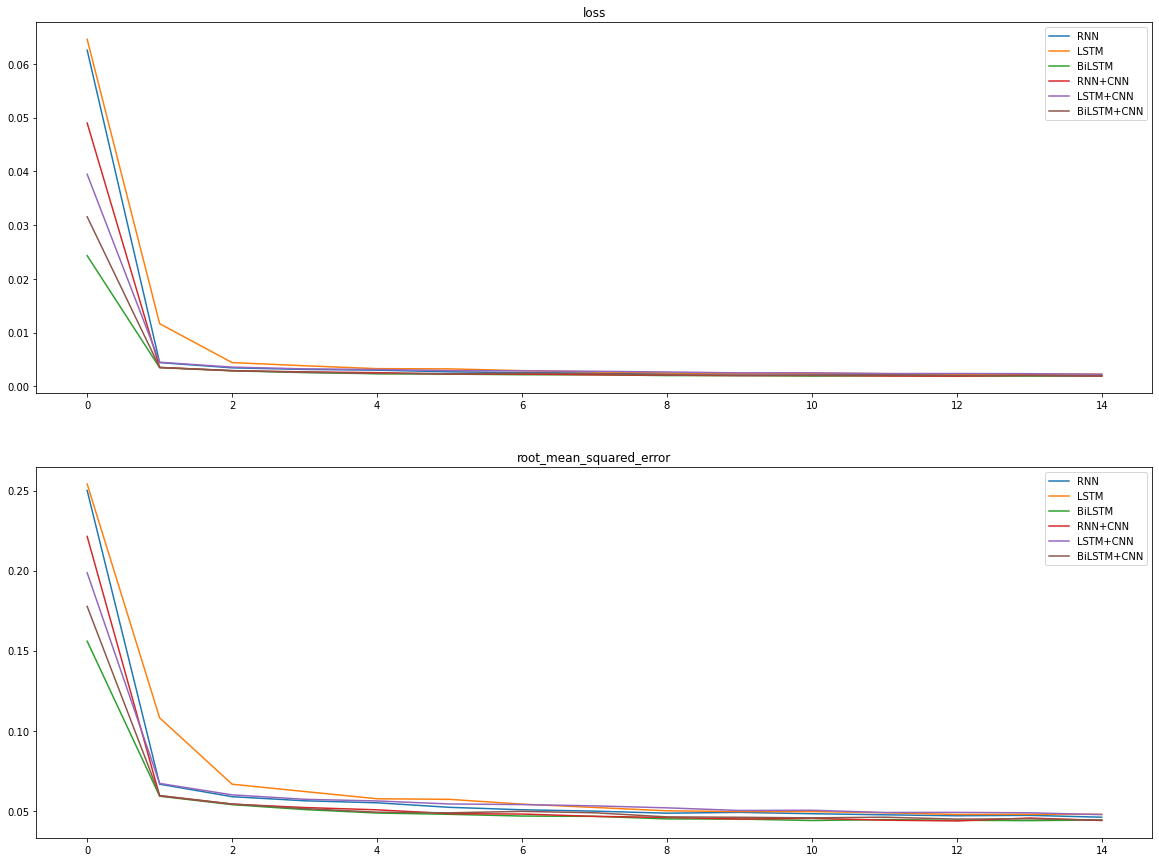

In [21]:
plt.figure(figsize=(20,15))
plt.subplot(2,1,1)
plt.title('loss')
for name in history.keys():
    plt.plot(history[name].history['loss'], label=f'{name}')
plt.legend()

plt.subplot(2,1,2)
plt.title('root_mean_squared_error')
for name in history.keys():
    plt.plot(history[name].history['root_mean_squared_error'], label=f'{name}')
plt.legend()

In [22]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error

def MDAPE(y_true, y_pred):
    return np.median((np.abs(np.subtract(y_true, y_pred)/ y_true))) * 100

def prediction(dict_model, data, scaler, compare):
    dict_predict = {}
    for name_model in dict_model.keys():
        # predict
        t0 = time.time()                
        if name_model in ['RNN', 'LSTM', 'BiLSTM', 'RNN+CNN', 'LSTM+CNN', 'BiLSTM+CNN']:
            y_pred = dict_model[name_model].predict(data['x_test'], verbose=0)
        else:
            y_pred = dict_model[name_model].predict(data['x2d_test'])
        time_test = time.time() - t0     
        
        # inverse về dữ liệu thực
        y_test_inverse = scaler.inverse_transform(data['y_test'])
        y_test = y_test_inverse[:,0]        # chỉ lấy giá cổ phiếu (giá đóng cửa)
        
        y_pred_inverse = scaler.inverse_transform(y_pred)
        y_pred = y_pred_inverse[:,0]        # chỉ lấy giá cổ phiếu (giá đóng cửa)

        # lưu kết quả đánh giá
        dict_predict[name_model] = {'y_test' : y_test, 'y_pred' : y_pred}

        # đánh giá độ chính xác
        mdape = MDAPE(y_test, y_pred)
        MAPE = mean_absolute_percentage_error(y_test, y_pred)
        MAE = mean_absolute_error(y_test, y_pred)
        MSE = mean_squared_error(y_test, y_pred)

        # lưu đánh giá
        compare[name_model]['time_test'] = time_test
        compare[name_model]['MDAPE'] = mdape
        compare[name_model]['MAPE'] = MAPE
        compare[name_model]['MAE'] = MAE
        compare[name_model]['MSE'] = MSE

    return dict_predict

In [23]:
# vẽ biểu đồ giá trị thực và giá trị dự đoán
def plot_true_pred(dict_predict, date, n_input):
    index_date = date['test'][n_input:]

    no_cols = len(dict_predict)
    plt.figure(figsize=(20,40))
    for idx, name_model in enumerate(dict_predict.keys()):
        
        df_true = pd.DataFrame(dict_predict[name_model]['y_test'], columns=['Stock Price'], index=index_date)
        df_pred = pd.DataFrame(dict_predict[name_model]['y_pred'], columns=['Stock Price'], index=index_date)

        plt.subplot(no_cols,2,idx+1)    
        plt.plot(df_true['Stock Price'], color = "red", label = "y_true")
        plt.plot(df_pred['Stock Price'], color = "blue", label = "y_pred")
        plt.legend()
        plt.title(name_model)

    plt.suptitle('Giá trị thực và giá trị dự đoán', y=0.91, fontweight='bold', fontsize='20')
    plt.show()

In [24]:
def plot_forecasting(dict_model, data, scaler, date, n_future, n_past):
    no_cols = len(dict_model)
    plt.figure(figsize=(20,40))
    n_features = len(data['y_train'][-1])

    for idx, name_model in enumerate(dict_model.keys()):
        predicts = []

        if name_model in ['RNN', 'LSTM', 'BiLSTM', 'RNN+CNN', 'LSTM+CNN', 'BiLSTM+CNN']:
            current_batch = np.array([np.concatenate((data['x_train'][-1][1:],[data['y_train'][-1]]), axis = 0)])
            for i in range(n_future):        
                current_pred = dict_model[name_model].predict(current_batch, verbose=0)[0]      # nhận giá trị dự đoán cho đợt đầu tiên        
                predicts.append(current_pred)                       
                current_batch_rmv_first = current_batch[:,1:,:]     # xóa giá trị đầu tiên        
                current_batch = np.append(current_batch_rmv_first, [[current_pred]],axis=1)
        else:
            current_batch = np.array([np.concatenate((data['x2d_train'][-1][n_features:],data['y_train'][-1]))])

            for i in range(n_future):      
                current_pred = dict_model[name_model].predict(current_batch)[0]         # nhận giá trị dự đoán cho đợt đầu tiên        
                predicts.append(current_pred)                       
                current_batch_rmv_first = current_batch[0][n_features:]                 # xóa giá trị đầu tiên        
                current_batch = np.array([np.concatenate((current_batch_rmv_first, current_pred))])

        past = data['y_train'][-n_past:]
        future = np.concatenate((past,np.array(predicts)), axis = 0)

        past = scaler.inverse_transform(past)
        future = scaler.inverse_transform(future)
        
        past_day = date[-n_past:]
        future_date = list(past_day) + pd.date_range(list(past_day)[-1], periods=(n_future), freq='D').tolist()

        past_df = pd.DataFrame(past[:,0], columns=['Stock Price'], index=past_day) 
        future_df = pd.DataFrame(future[:,0], columns=['Stock Price'], index=future_date)
        
        plt.subplot(no_cols,2,idx+1) 
        plt.plot(future_df['Stock Price'], label='future')
        plt.plot(past_df['Stock Price'], label='past')
        plt.legend()
        plt.title(name_model)
        
    plt.suptitle('Dự đoán giá cột phiếu\n14 ngày tiếp theo', y=0.91, fontweight='bold', fontsize='20')
    plt.show()

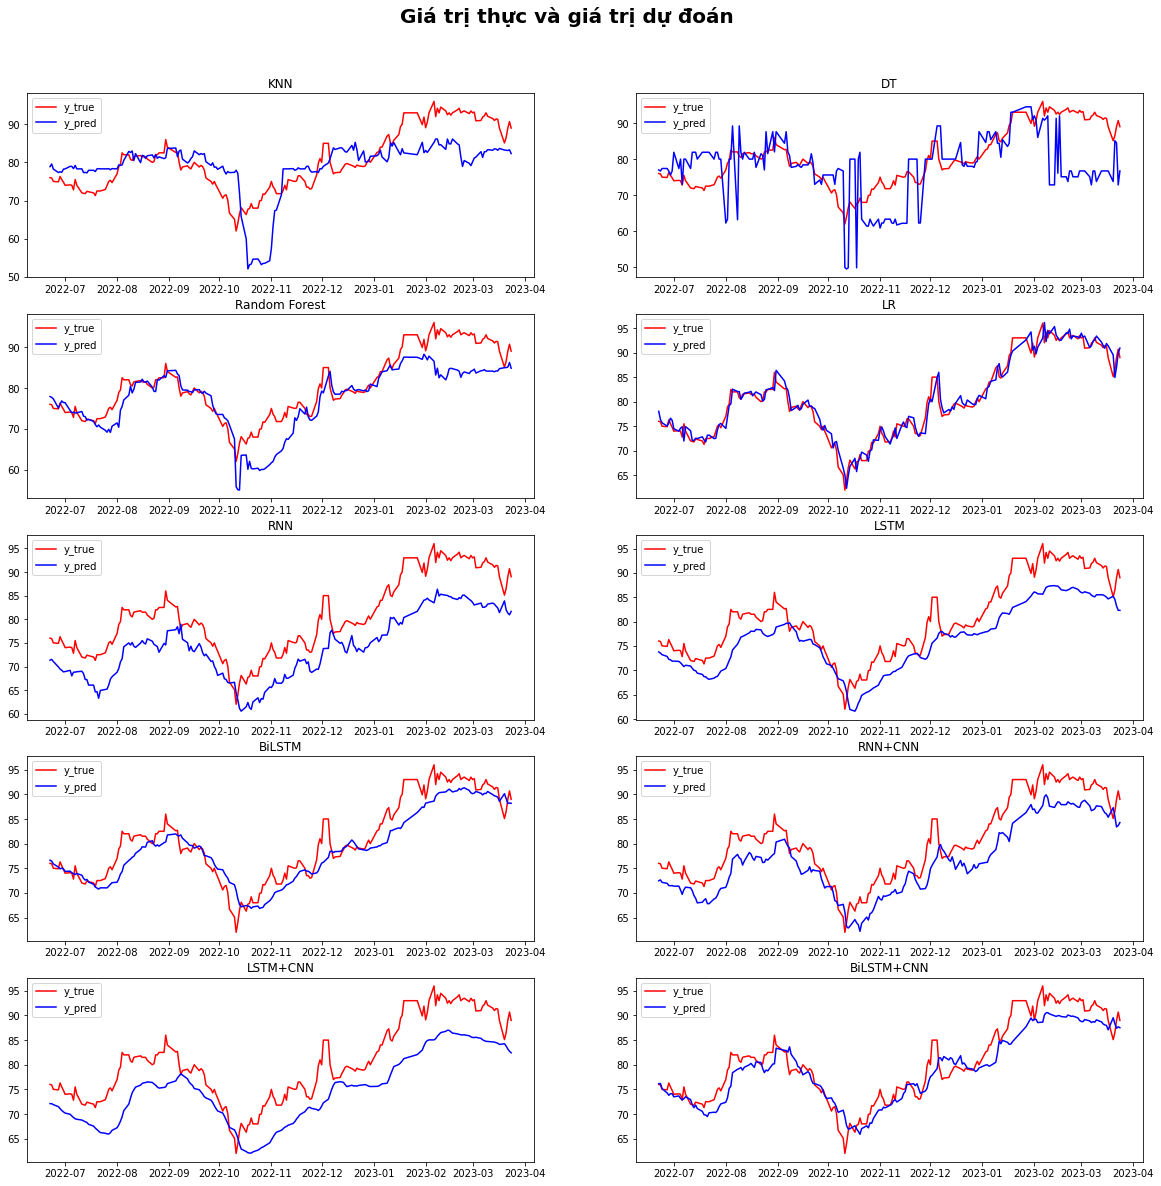

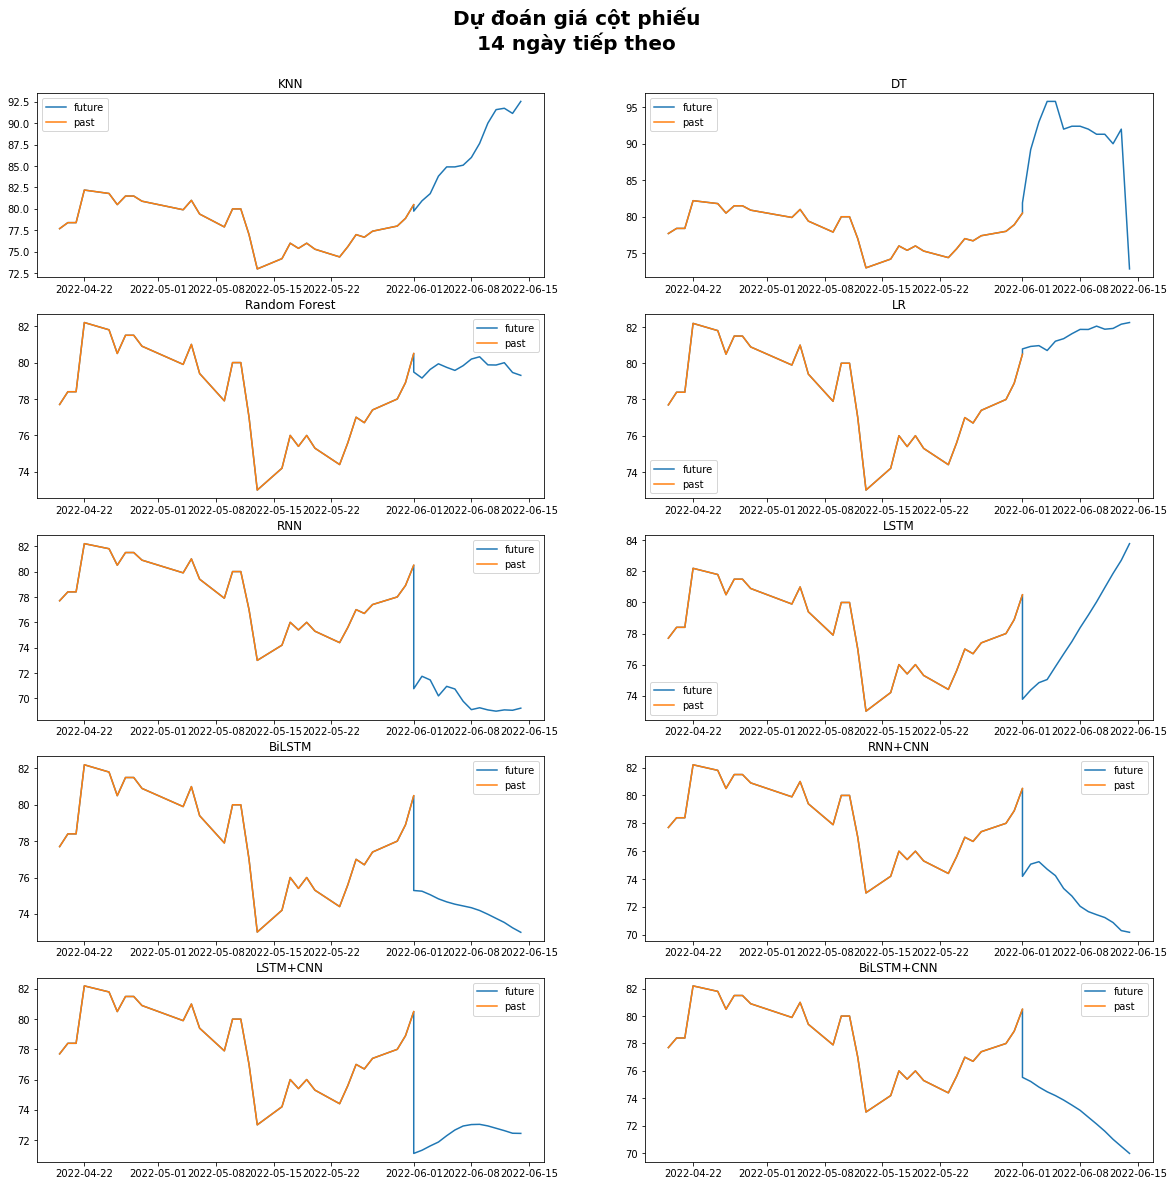

In [25]:
# dự đoán
dict_predict = prediction(dict_model, data, scaler, compare_model)

# vẽ biểu đồ giá trị thực và tương lai
plot_true_pred(dict_predict, index_split, 14)

# dự đoán giá cổ phiếu các ngày tiếp theo
plot_forecasting(dict_model, data, scaler, index_split['train'][14:], n_future=14, n_past=30)

# 6. So sánh các model

In [26]:
df_compare = pd.DataFrame(compare_model).T
df_compare.style.highlight_min(color = 'orange', axis = 0)

,time_train,time_test,MDAPE,MAPE,MAE,MSE
KNN,0.001184,0.122291,6.208312,0.070513,5.581884,49.534502
DT,0.232336,0.000332,6.064208,0.084189,6.724105,79.670567
Random Forest,18.550185,0.032546,3.117497,0.047192,3.812185,27.011280
LR,0.084111,0.000363,1.028224,0.014333,1.136751,2.406619
RNN,12.062212,0.488414,8.074947,0.079002,6.403584,47.087474
LSTM,24.873242,0.456406,5.165956,0.050828,4.158943,22.913750
BiLSTM,49.506532,0.875856,2.353090,0.029970,2.413202,9.670712
RNN+CNN,13.455213,0.403062,5.041245,0.050673,4.100601,20.471390
LSTM+CNN,24.378181,0.478800,7.232134,0.070514,5.709540,39.672887
BiLSTM+CNN,45.300479,0.890691,2.599777,0.028787,2.341053,8.496638


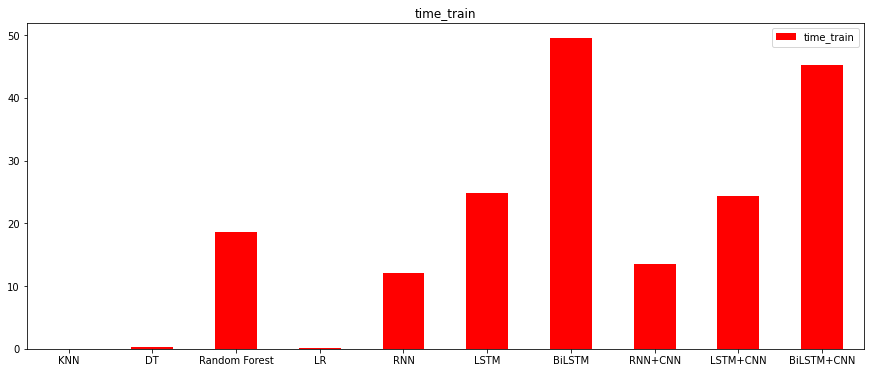

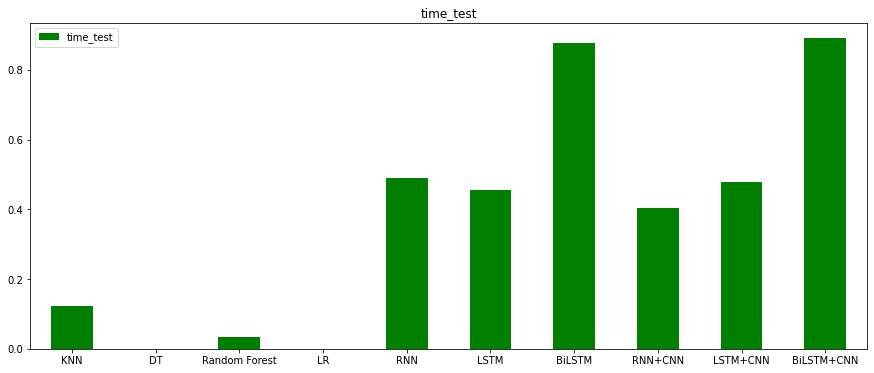

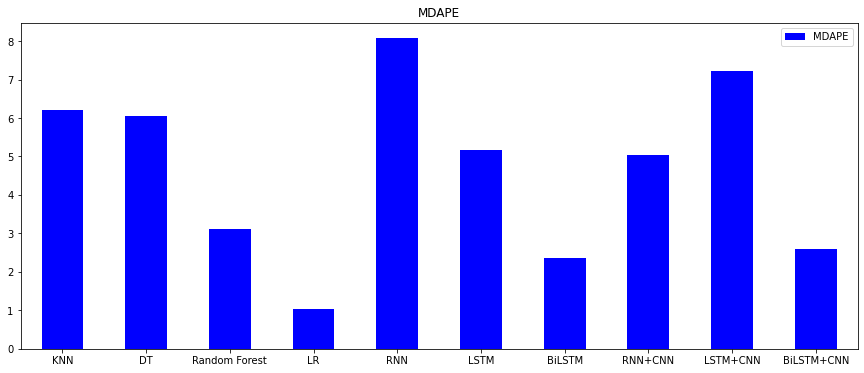

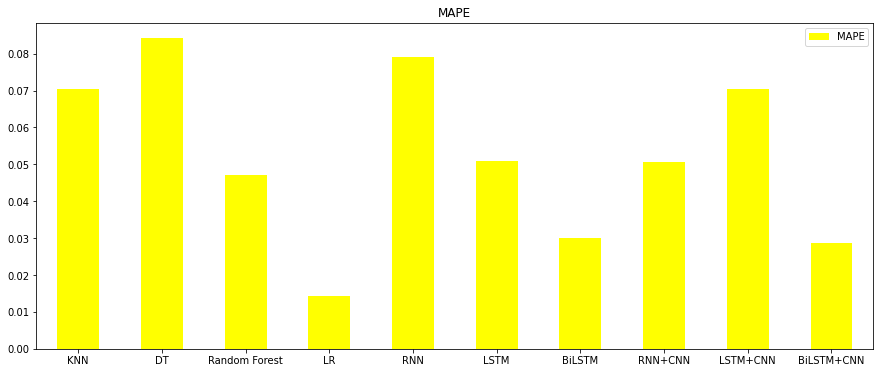

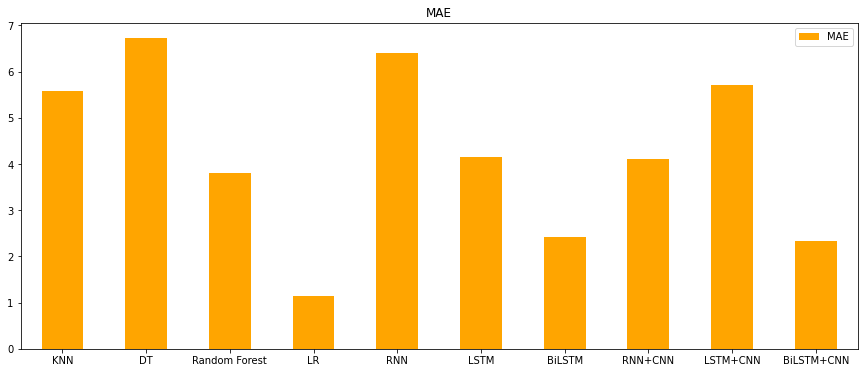

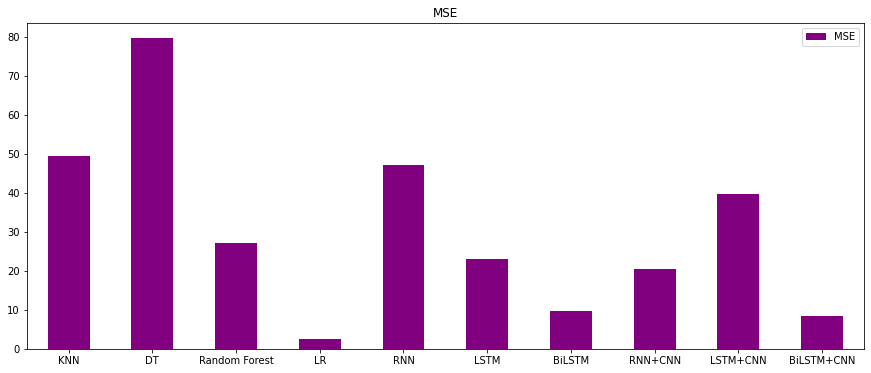

In [27]:
# vẽ biểu đồ so sánh các độ đo giữa các model với nhau
colors = ['red', 'green', 'blue', 'yellow', 'orange', 'purple']
for i, col in enumerate(df_compare.columns):
    df_compare.plot(kind= 'bar', y=col, color=colors[i], title=col, rot=0, figsize=(15,6))

# 7. Tìm đặc trưng ảnh hưởng nhất đến giá trị dự đoán

## 7.1 Chọn tập đặc trưng

In [28]:
# sử dụng correlation để xem sự tương qua dữ liệu
corrmat = df.corr()
corrmat.style.background_gradient(cmap="inferno")

,Giá điều chỉnh,Giá đóng cửa,GD khớp lệnh_KL,GD khớp lệnh_GT,GD thỏa thuận_KL,GD thỏa thuận_GT,Giá mở cửa,Giá cao nhất,Giá thấp nhất
Giá điều chỉnh,1.000000,0.941934,0.074389,0.447908,0.069560,0.099281,0.941012,0.941934,0.941064
Giá đóng cửa,0.941934,1.000000,0.055321,0.466421,0.053712,0.085856,0.998457,0.999323,0.999064
GD khớp lệnh_KL,0.074389,0.055321,1.000000,0.869218,0.025729,0.023359,0.050289,0.063288,0.042296
GD khớp lệnh_GT,0.447908,0.466421,0.869218,1.000000,0.046363,0.059608,0.461644,0.474077,0.454121
GD thỏa thuận_KL,0.069560,0.053712,0.025729,0.046363,1.000000,0.994203,0.054720,0.054637,0.054003
GD thỏa thuận_GT,0.099281,0.085856,0.023359,0.059608,0.994203,1.000000,0.086836,0.086621,0.086138
Giá mở cửa,0.941012,0.998457,0.050289,0.461644,0.054720,0.086836,1.000000,0.999090,0.999206
Giá cao nhất,0.941934,0.999323,0.063288,0.474077,0.054637,0.086621,0.999090,1.000000,0.998872
Giá thấp nhất,0.941064,0.999064,0.042296,0.454121,0.054003,0.086138,0.999206,0.998872,1.000000


<Axes: >

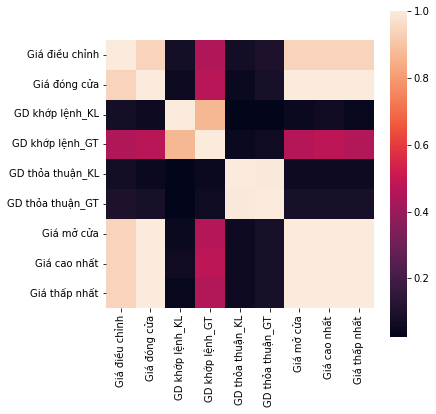

In [29]:
f,ax = plt.subplots(figsize=(6,6))
sns.heatmap(corrmat, square=True)

In [30]:
df_corr_close_price = pd.DataFrame(zip(corrmat.index, corrmat['Giá đóng cửa']), columns=['Features', 'Corr'])
df_corr_close_price = df_corr_close_price.sort_values(['Corr'], ascending =False,ignore_index=True)
df_corr_close_price

,Features,Corr
0,Giá đóng cửa,1.000000
1,Giá cao nhất,0.999323
2,Giá thấp nhất,0.999064
3,Giá mở cửa,0.998457
4,Giá điều chỉnh,0.941934
5,GD khớp lệnh_GT,0.466421
6,GD thỏa thuận_GT,0.085856
7,GD khớp lệnh_KL,0.055321
8,GD thỏa thuận_KL,0.053712


## 7.2 Dự đoán trên tập đặc trưng mới

In [31]:
features_new = ['Giá đóng cửa', 'Giá cao nhất', 'Giá thấp nhất', 'Giá mở cửa', 'Giá điều chỉnh']
df_new = df[features_new]
df_new

,Giá đóng cửa,Giá cao nhất,Giá thấp nhất,Giá mở cửa,Giá điều chỉnh
Ngày,,,,,
2015-01-05,31.9,32.1,31.4,31.7,16.67
2015-01-06,34.0,34.0,31.9,31.9,17.77
2015-01-07,33.6,34.6,33.1,34.1,17.56
2015-01-08,34.6,35.0,33.6,33.7,18.09
2015-01-09,36.9,37.0,34.9,34.9,19.29
...,...,...,...,...,...
2023-03-20,85.1,89.5,85.1,89.0,85.10
2023-03-21,86.5,89.9,85.4,85.4,86.50
2023-03-22,89.0,89.9,86.6,86.6,89.00


In [32]:
scaler_new = MinMaxScaler()
data_scaled_new = scaler_new.fit_transform(df_new)

data_split_new = split_Train_Test(data_scaled_new)
index_split_new = split_Train_Test(df_new.index)

data_new = generatorData(data_split_new, n_input=14)

dict_model_new = create_dict_model(n_features=5, n_input=14)

In [33]:
history_new, compare_new = training(dict_model_new, data_new)

KNN
DT
Random Forest
LR
RNN
Epoch 1/15
57/57 [==============================] - 3s 9ms/step - loss: 0.0485 - root_mean_squared_error: 0.2203
Epoch 2/15
57/57 [==============================] - 1s 10ms/step - loss: 0.0017 - root_mean_squared_error: 0.0411
Epoch 3/15
57/57 [==============================] - 1s 9ms/step - loss: 0.0010 - root_mean_squared_error: 0.0320
Epoch 4/15
57/57 [==============================] - 1s 10ms/step - loss: 8.4208e-04 - root_mean_squared_error: 0.0290
Epoch 5/15
57/57 [==============================] - 1s 10ms/step - loss: 7.6348e-04 - root_mean_squared_error: 0.0276
Epoch 6/15
57/57 [==============================] - 1s 10ms/step - loss: 6.3131e-04 - root_mean_squared_error: 0.0251
Epoch 7/15
57/57 [==============================] - 1s 10ms/step - loss: 6.3831e-04 - root_mean_squared_error: 0.0253
Epoch 8/15
57/57 [==============================] - 1s 10ms/step - loss: 5.9602e-04 - root_mean_squared_error: 0.0244
Epoch 9/15
57/57 [========================

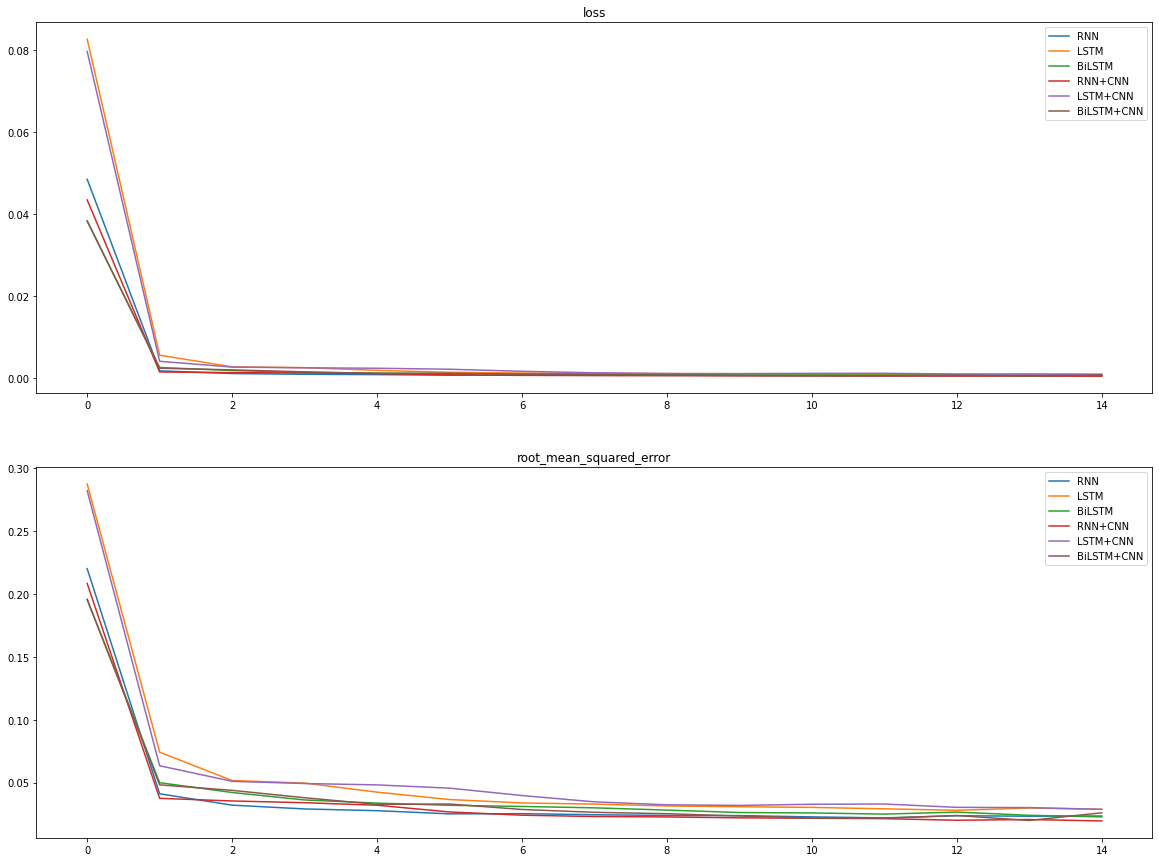

In [34]:
plt.figure(figsize=(20,15))
plt.subplot(2,1,1)
plt.title('loss')
for name in history_new.keys():
    plt.plot(history_new[name].history['loss'], label=f'{name}')
plt.legend()

plt.subplot(2,1,2)
plt.title('root_mean_squared_error')
for name in history_new.keys():
    plt.plot(history_new[name].history['root_mean_squared_error'], label=f'{name}')
plt.legend()

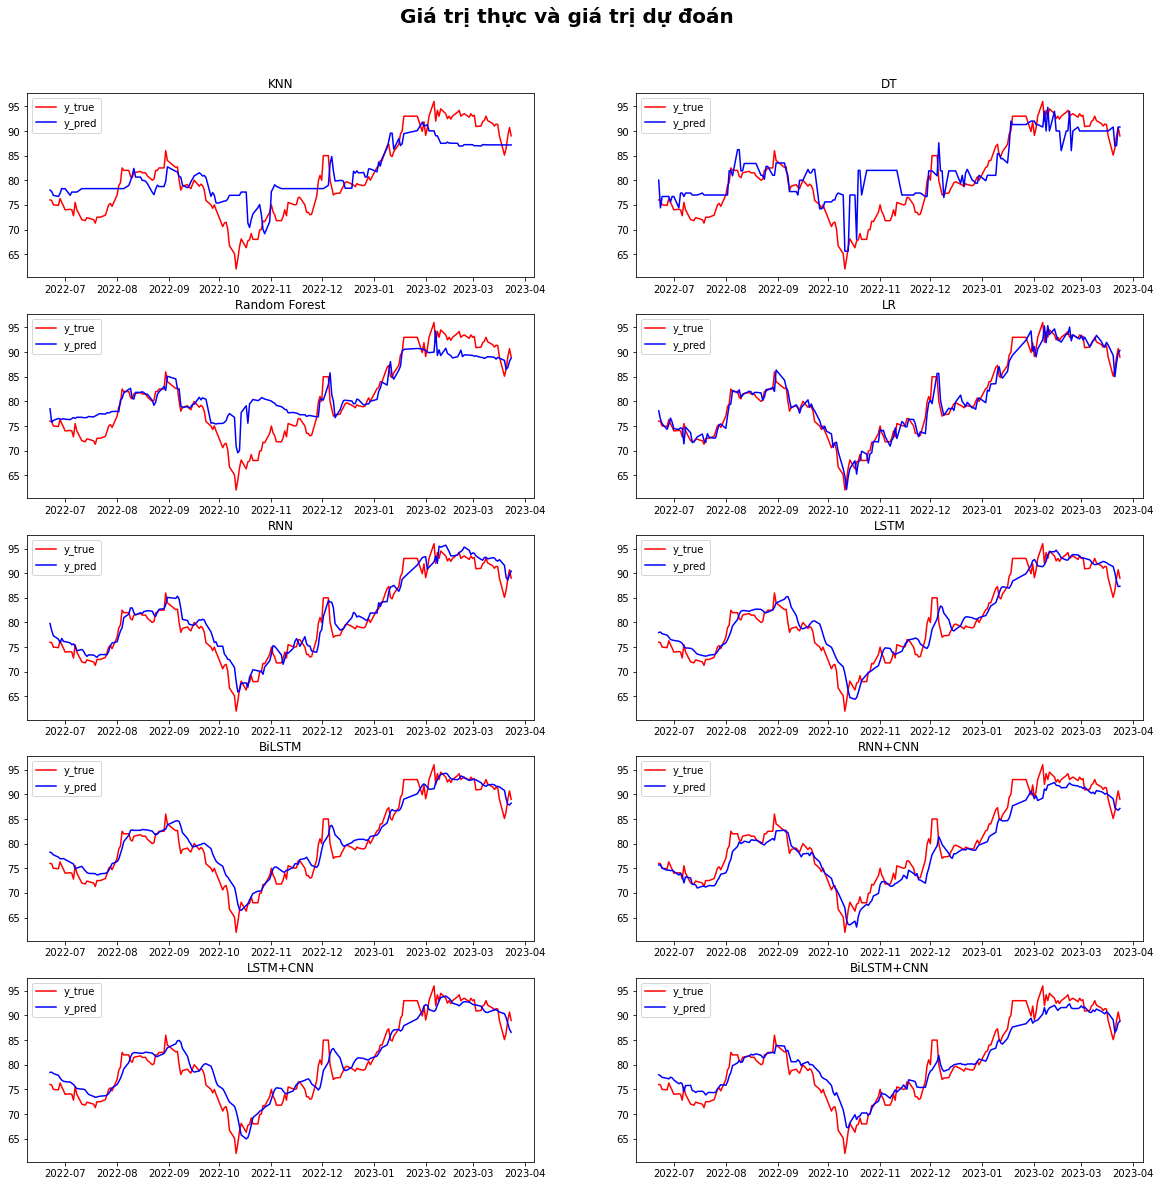

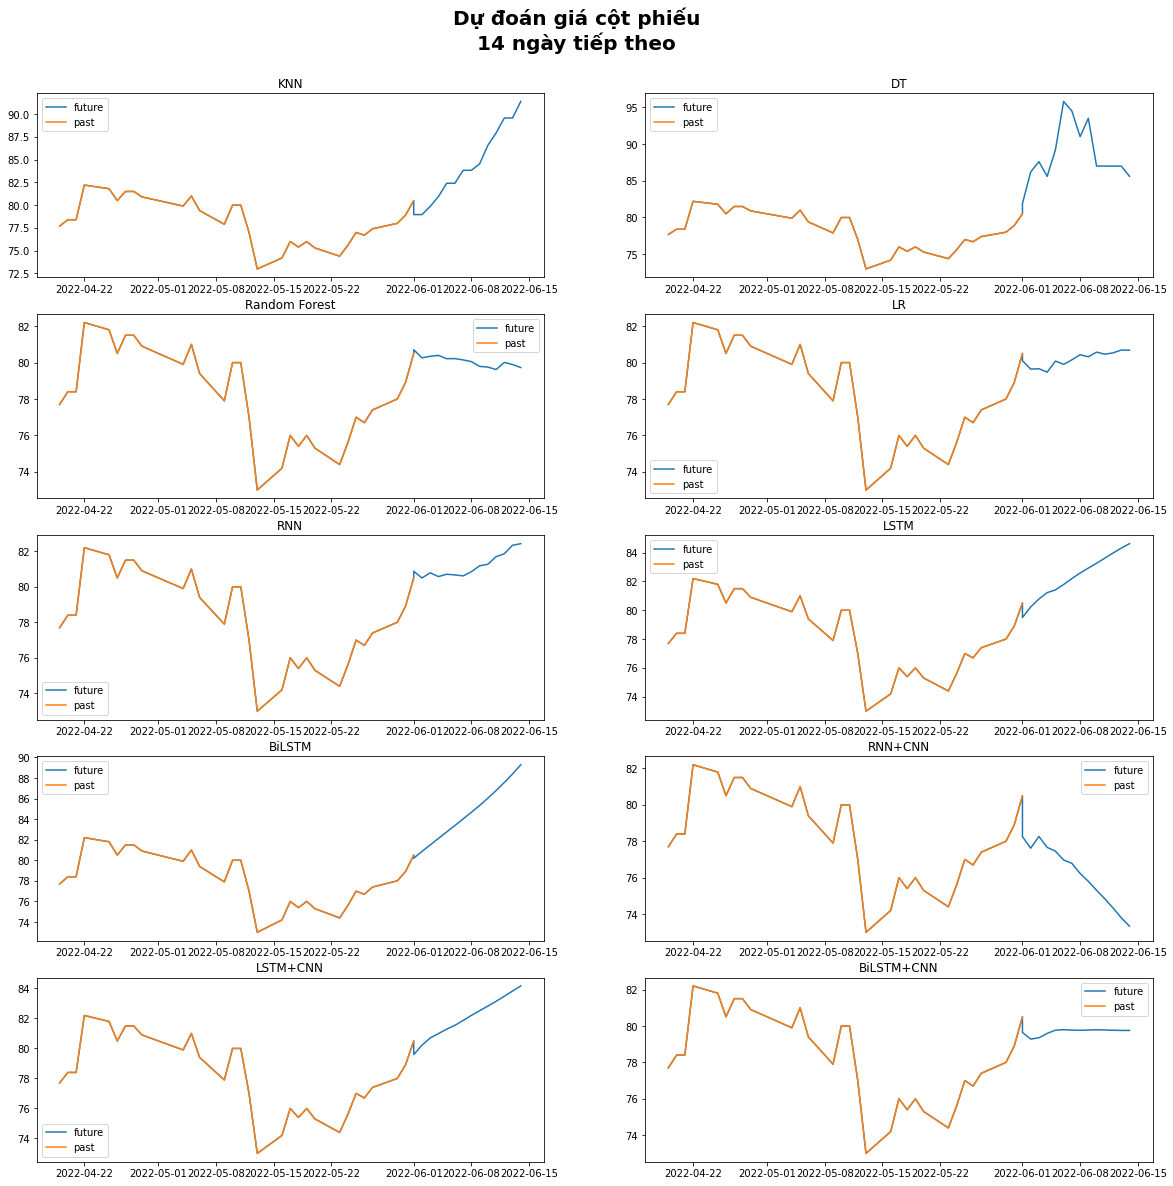

In [35]:
# dự đoán
dict_predict_new = prediction(dict_model_new, data_new, scaler_new, compare_new)

# vẽ biểu đồ giá trị thực và tương lai
plot_true_pred(dict_predict_new, index_split_new, 14)

# dự đoán giá cổ phiếu các ngày tiếp theo
plot_forecasting(dict_model_new, data_new, scaler_new, index_split_new['train'][14:], n_future=14, n_past=30)

In [36]:
df_compare_new = pd.DataFrame(compare_new).T
df_compare_new.style.highlight_min(color = 'orange', axis = 0)

,time_train,time_test,MDAPE,MAPE,MAE,MSE
KNN,0.001000,0.004502,3.943520,0.046470,3.618421,19.152229
DT,0.116169,0.000266,2.675615,0.043475,3.315263,20.160053
Random Forest,8.387314,0.024956,2.803664,0.039287,2.985600,16.697039
LR,0.010610,0.001215,1.074982,0.014931,1.187790,2.509034
RNN,12.396937,0.574154,1.832457,0.021711,1.709014,4.596704
LSTM,22.368792,0.522344,1.892603,0.024151,1.883810,5.887598
BiLSTM,49.777253,0.832707,1.892647,0.022737,1.765464,5.158896
RNN+CNN,13.254739,0.435011,1.716471,0.021668,1.736513,5.210585
LSTM+CNN,22.760459,0.515315,1.986368,0.025243,1.963344,6.350060
BiLSTM+CNN,45.479918,0.943737,1.911193,0.022660,1.778893,5.041548


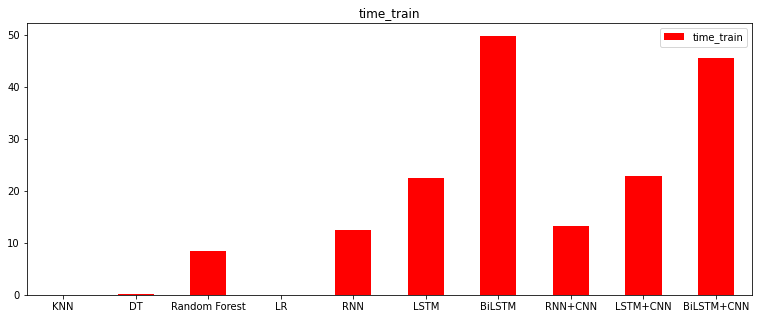

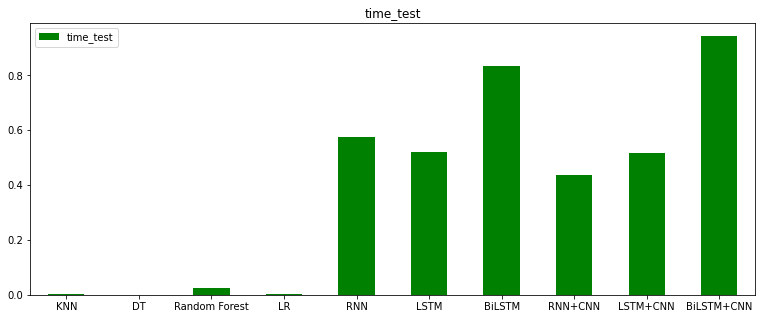

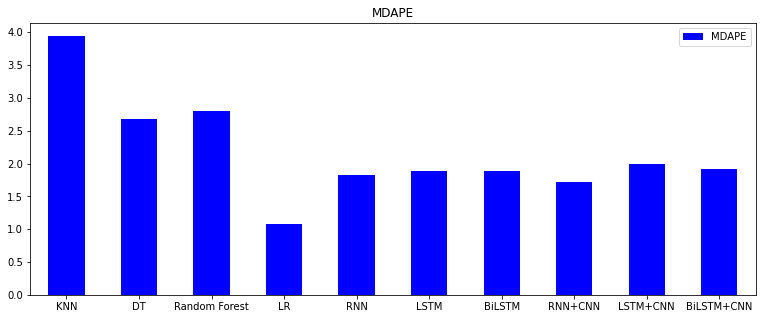

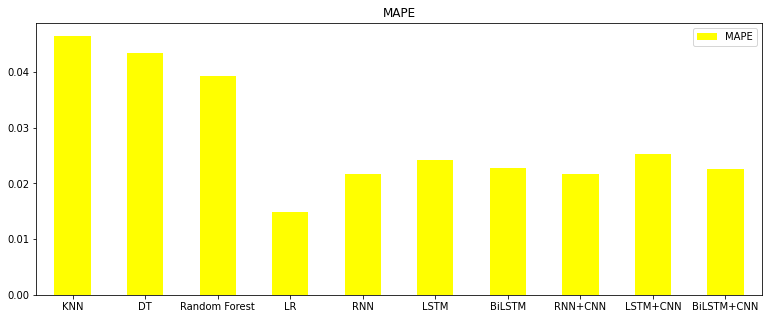

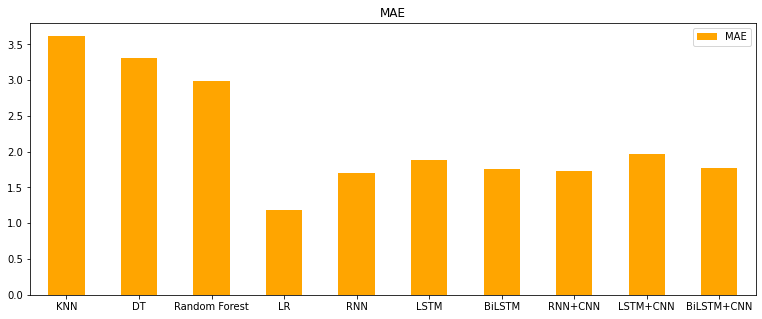

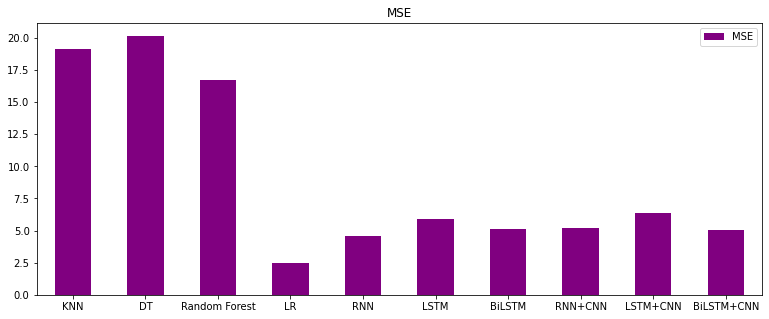

In [37]:
# vẽ biểu đồ so sánh các độ đo giữa các model với nhau
colors = ['red', 'green', 'blue', 'yellow', 'orange', 'purple']
for i, col in enumerate(df_compare_new.columns):
    df_compare_new.plot(kind= 'bar', y=col, color=colors[i], title=col, rot=0, figsize=(13,5))

## 7.3 So sánh với tập đặc trưng ban đầu

KNN


,time_train,time_test,MDAPE,MAPE,MAE,MSE
Feature Old,0.001184,0.122291,6.208312,0.070513,5.581884,49.534502
Feature New,0.001000,0.004502,3.943520,0.046470,3.618421,19.152229


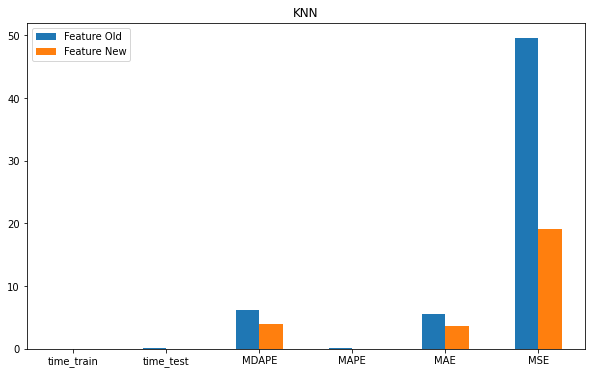

DT


,time_train,time_test,MDAPE,MAPE,MAE,MSE
Feature Old,0.232336,0.000332,6.064208,0.084189,6.724105,79.670567
Feature New,0.116169,0.000266,2.675615,0.043475,3.315263,20.160053


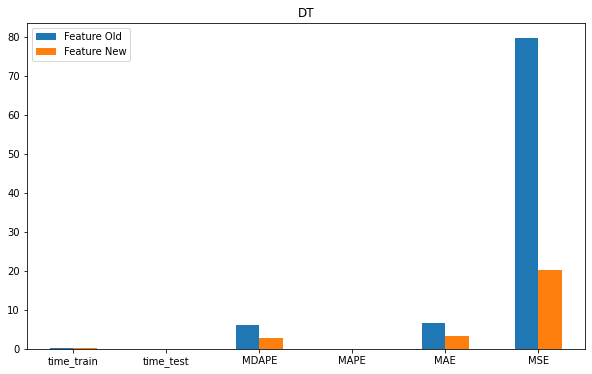

Random Forest


,time_train,time_test,MDAPE,MAPE,MAE,MSE
Feature Old,18.550185,0.032546,3.117497,0.047192,3.812185,27.011280
Feature New,8.387314,0.024956,2.803664,0.039287,2.985600,16.697039


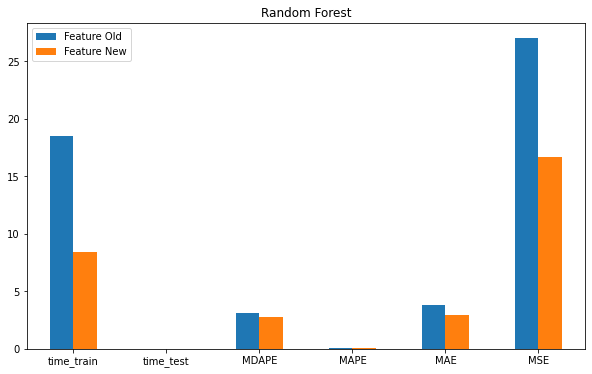

LR


,time_train,time_test,MDAPE,MAPE,MAE,MSE
Feature Old,0.084111,0.000363,1.028224,0.014333,1.136751,2.406619
Feature New,0.010610,0.001215,1.074982,0.014931,1.187790,2.509034


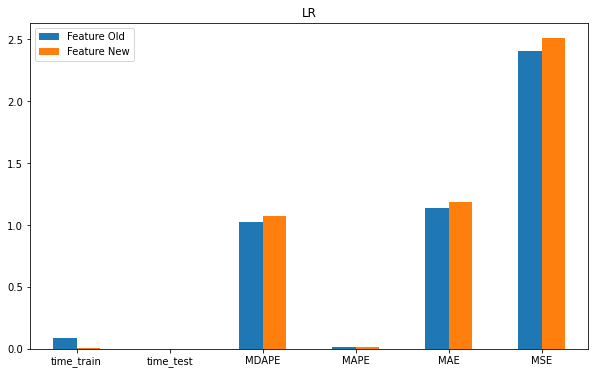

RNN


,time_train,time_test,MDAPE,MAPE,MAE,MSE
Feature Old,12.062212,0.488414,8.074947,0.079002,6.403584,47.087474
Feature New,12.396937,0.574154,1.832457,0.021711,1.709014,4.596704


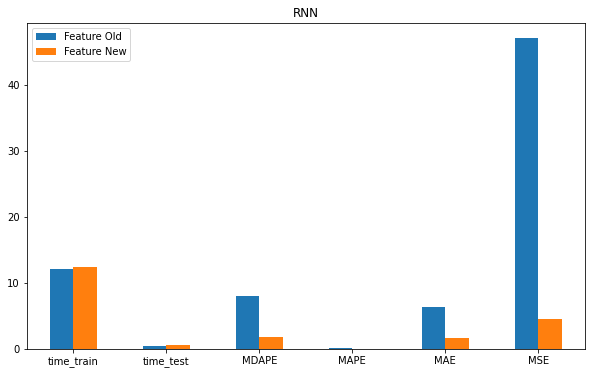

LSTM


,time_train,time_test,MDAPE,MAPE,MAE,MSE
Feature Old,24.873242,0.456406,5.165956,0.050828,4.158943,22.913750
Feature New,22.368792,0.522344,1.892603,0.024151,1.883810,5.887598


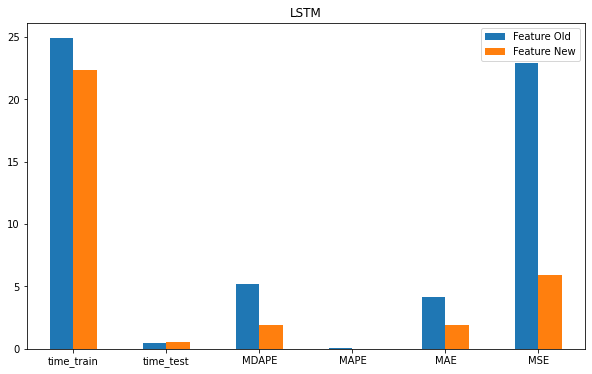

BiLSTM


,time_train,time_test,MDAPE,MAPE,MAE,MSE
Feature Old,49.506532,0.875856,2.353090,0.029970,2.413202,9.670712
Feature New,49.777253,0.832707,1.892647,0.022737,1.765464,5.158896


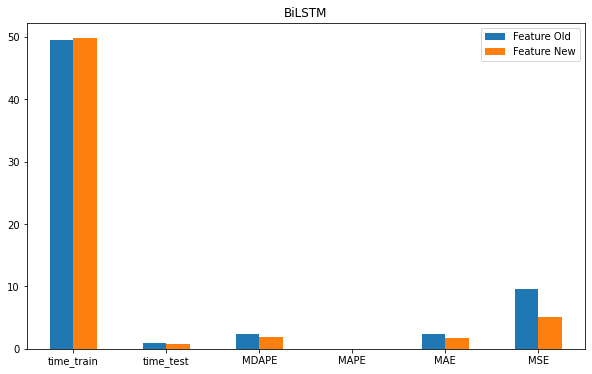

RNN+CNN


,time_train,time_test,MDAPE,MAPE,MAE,MSE
Feature Old,13.455213,0.403062,5.041245,0.050673,4.100601,20.471390
Feature New,13.254739,0.435011,1.716471,0.021668,1.736513,5.210585


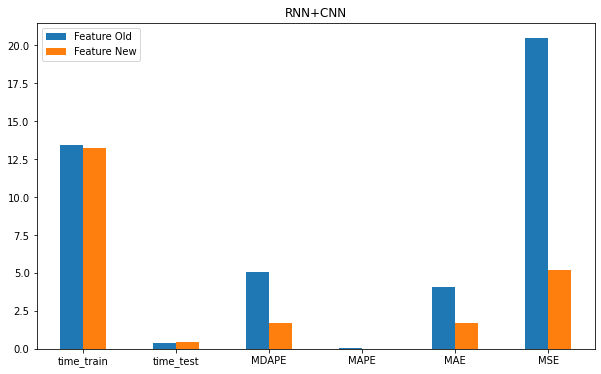

LSTM+CNN


,time_train,time_test,MDAPE,MAPE,MAE,MSE
Feature Old,24.378181,0.478800,7.232134,0.070514,5.709540,39.672887
Feature New,22.760459,0.515315,1.986368,0.025243,1.963344,6.350060


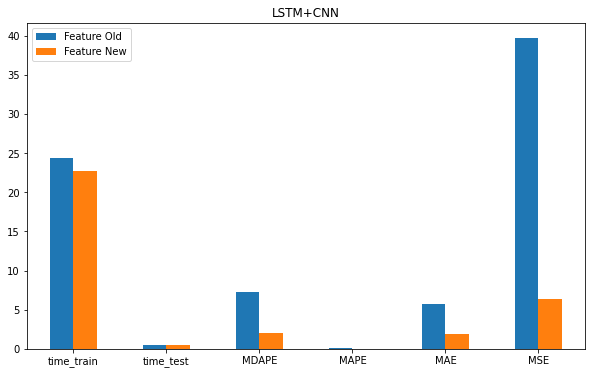

BiLSTM+CNN


,time_train,time_test,MDAPE,MAPE,MAE,MSE
Feature Old,45.300479,0.890691,2.599777,0.028787,2.341053,8.496638
Feature New,45.479918,0.943737,1.911193,0.022660,1.778893,5.041548


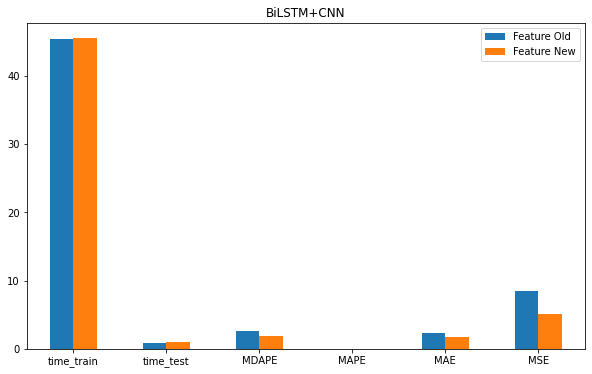

In [38]:
for name_model in compare_model.keys():
    print(name_model)
    df_old_new = pd.DataFrame({'Feature Old': compare_model[name_model], 'Feature New': compare_new[name_model]})
    display(df_old_new.T.style.highlight_min(color = 'orange', axis = 0))
    colors = ['red', 'green', 'blue', 'yellow', 'orange', 'purple']
    df_old_new.plot(title=name_model, kind= 'bar', rot=0, figsize=(10,6))
    plt.show()
    print('='*80)